## Software empleado

In [30]:
# Bibliotecas
import os, sys
import torch
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, Tuple, Optional, Union

In [31]:
# %load_ext autoreload
# %autoreload 2
# import visual_utils

In [32]:
sys.path.append(os.path.abspath('notebooks/'))

# Código propio
from visual_utils import * 


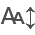

In [33]:
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

# PROBLEMA 1
# ESTIMACIÓN DE EDAD

## Carga de los resultados y obtención de métricas

In [34]:
# Carga de datos
df_AE_raw = pd.read_csv('results/AE_maxillofacial_test_results.csv')

display(df_AE_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [35]:
# Nueva columna: error absoluto
df_AE_raw['absolute_error'] = (df_AE_raw['true_value'] - df_AE_raw['pred_point_value']).abs()

# Nueva columna: error cuadrático
df_AE_raw['squared_error'] = (df_AE_raw['true_value'] - df_AE_raw['pred_point_value']).pow(2)

# Nueva columna: tamaño del intervalo medio
df_AE_raw['pred_interval_width'] = df_AE_raw['pred_upper_bound'] - df_AE_raw['pred_lower_bound']

# Nueva columna: cobertura (true/false)
df_AE_raw['is_covered'] = (df_AE_raw['true_value'] >= df_AE_raw['pred_lower_bound']) & \
                          (df_AE_raw['true_value'] <= df_AE_raw['pred_upper_bound'])

# Nueva columna: interval score  
alpha = 1 - df_AE_raw['confidence']
df_AE_raw['interval_score'] = (
    (df_AE_raw['pred_upper_bound'] - df_AE_raw['pred_lower_bound']) 
    + (2 / alpha) * (df_AE_raw['pred_lower_bound'] - df_AE_raw['true_value']).clip(lower=0) 
    + (2 / alpha) * (df_AE_raw['true_value'] - df_AE_raw['pred_upper_bound']).clip(lower=0)
)

display(df_AE_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [36]:
# Agrupar y calcular métricas
df_AE_by_run = (
    df_AE_raw
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .agg(
        mean_absolute_error=('absolute_error', 'mean'),
        mean_squared_error=('squared_error', 'mean'),
        empirical_coverage=('is_covered', 'mean'),
        mean_interval_width=('pred_interval_width', 'mean'),
        mean_interval_score=('interval_score', 'mean')
    )
    .reset_index()
)

display(df_AE_by_run)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Tabla resumen por ejecución y media

In [37]:
# Redondear valores y formatear porcentaje
df_AE_by_run_to_show = df_AE_by_run.copy()
df_AE_by_run_to_show['mean_absolute_error'] = df_AE_by_run_to_show['mean_absolute_error'].round(2)
df_AE_by_run_to_show['mean_squared_error'] = df_AE_by_run_to_show['mean_squared_error'].round(2)
df_AE_by_run_to_show['empirical_coverage'] = (df_AE_by_run_to_show['empirical_coverage'] * 100).round(2)
df_AE_by_run_to_show['mean_interval_width'] = df_AE_by_run_to_show['mean_interval_width'].round(2)
df_AE_by_run_to_show['mean_interval_score'] = df_AE_by_run_to_show['mean_interval_score'].round(2)

# Ordenar por iteración y por tipo de predicción
def sort_by_column(df, column, custom_order=None):
    if custom_order:
        df[column] = pd.Categorical(df[column], categories=custom_order, ordered=True)
    return df.sort_values(column)

df_AE_by_run_to_show = sort_by_column(df_AE_by_run_to_show, 'iteration')
custom_order = ['base', 'ICP', 'QR', 'CQR']
df_AE_by_run_to_show = sort_by_column(df_AE_by_run_to_show, 'pred_model_type', custom_order)

display(df_AE_by_run_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [38]:
# Agrupar por tipo de modelo y confianza
df_AE_by_pred_model_type_to_show = (
    df_AE_by_run
    .groupby(['pred_model_type', 'confidence'])
    .apply(lambda group: pd.Series({
        'mean_mean_absolute_error': round(group['mean_absolute_error'].mean(), 2),
        'mean_mean_squared_error': round(group['mean_squared_error'].mean(), 2),
        'mean_empirical_coverage': round(group['empirical_coverage'].mean() * 100, 2), 
        'mean_mean_interval_width': round(group['mean_interval_width'].mean(), 2),
        'mean_mean_interval_score': round(group['mean_interval_score'].mean(), 2)
    }))
    .reset_index()
)

# Ordenar por tipo de predicción
custom_order = ['base', 'ICP', 'QR', 'CQR']
df_AE_by_pred_model_to_show = sort_by_column(df_AE_by_pred_model_type_to_show, 'pred_model_type', custom_order)

display(df_AE_by_pred_model_type_to_show)

/tmp/ipykernel_34167/3968440076.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Gráfica de dispersión Empirical Coverage - Mean Interval Width

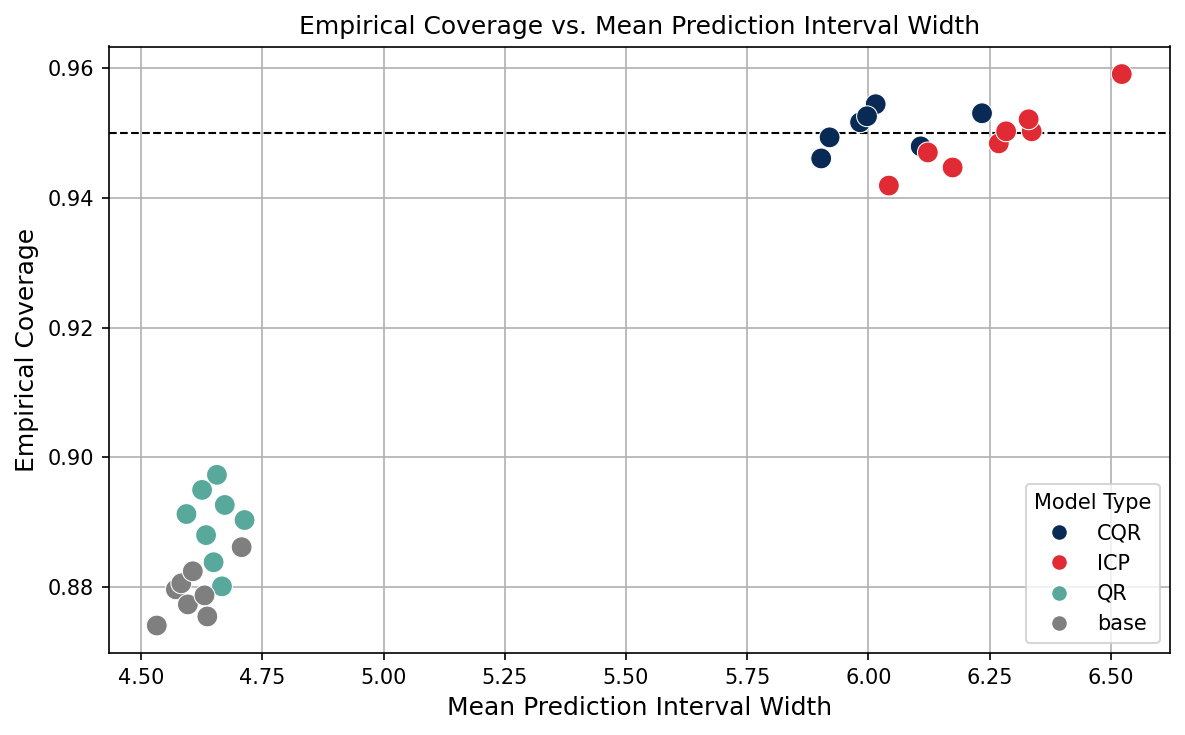

In [39]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}
df_AE_by_run_to_plot = df_AE_by_run.copy()
df_AE_by_run_to_plot['color'] = df_AE_by_run_to_plot['pred_model_type'].map(color_dict).fillna('black')

#
plot_coverage_vs_interval_width(
    mean_pred_interval_widths = df_AE_by_run_to_plot['mean_interval_width'],
    empirical_coverages = df_AE_by_run_to_plot['empirical_coverage'],
    model_types = df_AE_by_run_to_plot['pred_model_type'],
    colors = df_AE_by_run_to_plot['color'],
    confidence_level = 0.95,
    figsize=(8,5),
    dpi=150
)

## Histograma del ancho del intervalo con distinción de cobertura

In [40]:
# Añadir columna de ranking para 'mean_interval_score' dentro de cada grupo
df_AE_by_run = (
    df_AE_by_run
    .sort_values(['pred_model_type', 'confidence', 'mean_interval_width'])
    .assign(
        ranking_mean_interval_score=lambda x: x.groupby(['pred_model_type', 'confidence'])['mean_interval_score']
                                             .rank(method='dense')
    )
)

# Filtrar las mejores ejecuciones (ranking = 1)
best_runs = (
    df_AE_by_run[df_AE_by_run['ranking_mean_interval_score'] == 1]
    [['pred_model_type', 'confidence', 'iteration']]
)

# Unir con los datos originales para obtener solo la instancias de las mejores ejecuciones
df_best_AE_raw = pd.merge(
    df_AE_raw,
    best_runs,
    on=['pred_model_type', 'confidence', 'iteration'],
    how='inner'  # Solo conserva las coincidencias
)

display(df_best_AE_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


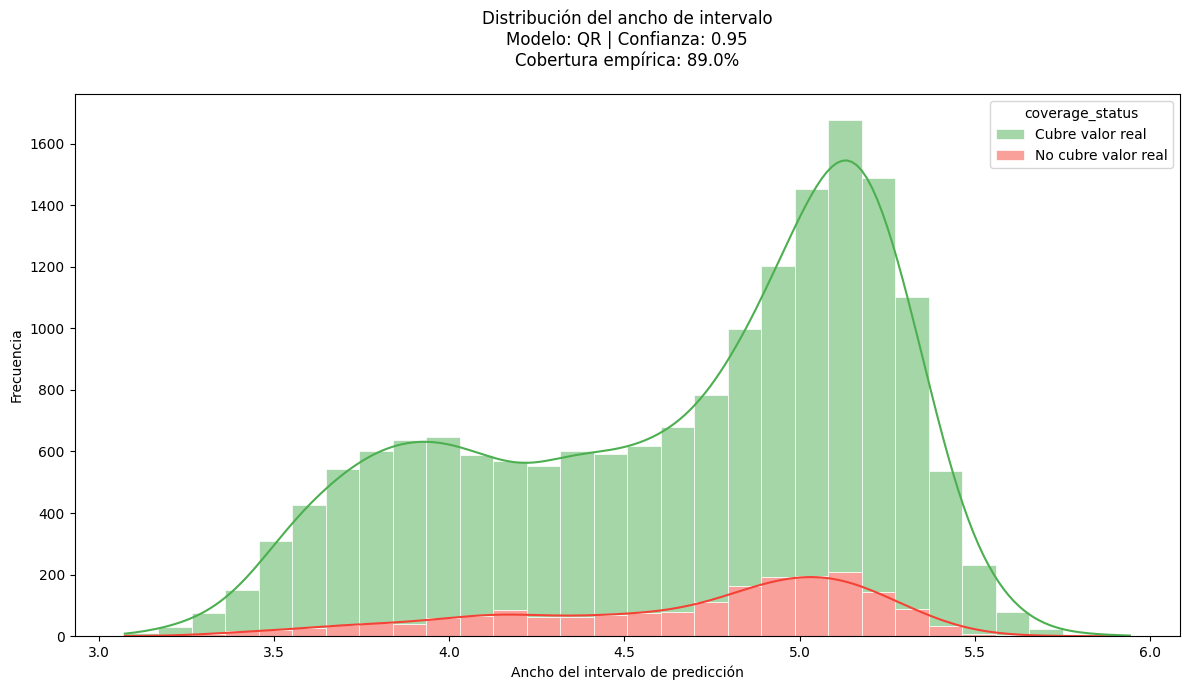

In [41]:
# Ejemplo de cómo usar la función
fig = plot_interval_width_histogram(df_AE_raw, pred_model_type='QR', confidence=0.95)
plt.show()

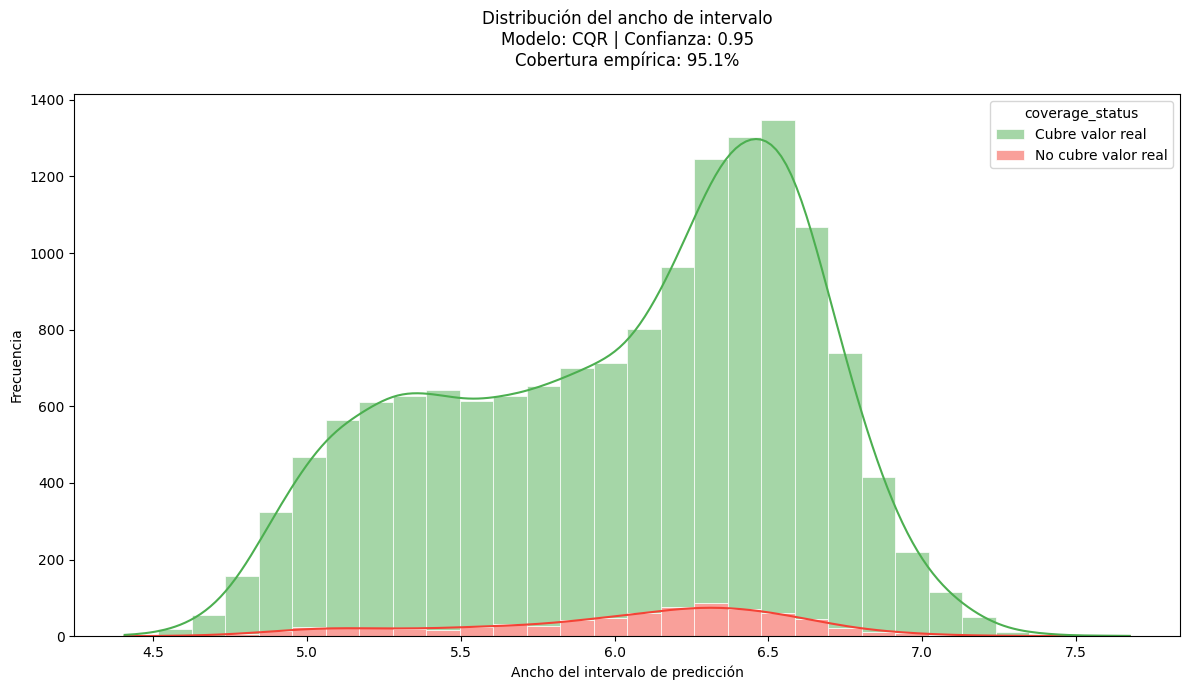

In [42]:
# Ejemplo de cómo usar la función
fig = plot_interval_width_histogram(df_AE_raw, pred_model_type='CQR', confidence=0.95)
plt.show()

## Análisis de la cobertura por tamaño del intervalo

In [68]:
# Calcula el ancho del intervalo si no está ya en el dataframe
df_best_AE_raw['pred_interval_width'] = df_best_AE_raw['pred_upper_bound'] - df_best_AE_raw['pred_lower_bound']

# Clasifica en deciles dentro de cada grupo {pred_model_type, confidence}
df_best_AE_raw['interval_width_decile'] = df_best_AE_raw.groupby(
    ['pred_model_type', 'confidence']
)['pred_interval_width'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')  # q=10 para deciles
)

# Calcula la cobertura empírica por decil
coverage_by_decile = df_best_AE_raw.groupby(
    ['pred_model_type', 'confidence', 'interval_width_decile']
).agg(
    mean_coverage=('is_covered', 'mean'),  # % de cobertura empírica
    mean_interval_width=('pred_interval_width', 'mean'),  # Ancho promedio del intervalo en el decil
    mean_interval_score=('interval_score', 'mean'),
    count=('is_covered', 'count')  # Número de muestras en el decil
).reset_index()

# Opcional: Ordenar para mejor visualización
coverage_by_decile = coverage_by_decile.sort_values(
    ['pred_model_type', 'confidence', 'interval_width_decile']
)

coverage_by_decile_to_show = coverage_by_decile.copy()
coverage_by_decile_to_show['mean_coverage'] = (coverage_by_decile_to_show['mean_coverage'] * 100).round(2)
coverage_by_decile_to_show['mean_interval_width'] = coverage_by_decile_to_show['mean_interval_width'].round(2)
coverage_by_decile_to_show['mean_interval_score'] = coverage_by_decile_to_show['mean_interval_score'].round(2)

display(coverage_by_decile_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Análisis de la cobertura por edad en entero

# PROBLEMA 2 
# ESTIMACIÓN DE MAYORÍA DE EDAD

## Carga de resultados

In [44]:
# Carga de datos
df_AMM_raw = pd.read_csv('results/AMM_maxillofacial_test_results.csv')

display(df_AMM_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [45]:
# Nueva columna: verdaderos positivos
df_AMM_raw['TP'] = (df_AMM_raw['pred_class'] == 1) & (df_AMM_raw['true_class'] == 1)

# Nueva columna: verdaderos negativos
df_AMM_raw['TN'] = (df_AMM_raw['pred_class'] == 0) & (df_AMM_raw['true_class'] == 0)

# falsos positivos
df_AMM_raw['FP'] = (df_AMM_raw['pred_class'] == 1) & (df_AMM_raw['true_class'] == 0)

# Nueva columna: falsos negativos
df_AMM_raw['FN'] = (df_AMM_raw['pred_class'] == 0) & (df_AMM_raw['true_class'] == 1)

# Nueva columna: cobertura (true/false)
df_AMM_raw['is_covered'] = ((df_AMM_raw['true_class'] == 0) & (df_AMM_raw['pred_set_under_18'] == 1)) | \
                          ((df_AMM_raw['true_class'] == 1) & (df_AMM_raw['pred_set_over_18'] == 1))
                          
# Nueva columna: tamaño del conjunto de predicción
df_AMM_raw['pred_set_size'] = df_AMM_raw['pred_set_under_18'] + df_AMM_raw['pred_set_over_18']

# Nueva columna: set score
alpha = 1 - df_AMM_raw['confidence']
df_AMM_raw['set_score'] = df_AMM_raw['pred_set_size'] + 1/alpha * (~df_AMM_raw['is_covered'])

display(df_AMM_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [46]:
# Agrupar y calcular métricas
df_AMM_by_run = (
    df_AMM_raw
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': (g['TP'].sum() + g['TN'].sum()) / len(g),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean()
    }))
    .reset_index()
)

display(df_AMM_by_run)

/tmp/ipykernel_34167/2631375322.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Tabla resumen por ejecución y media

In [47]:
# Redondear valores y formatear porcentaje
df_AMM_by_run_to_show = df_AMM_by_run.copy()
df_AMM_by_run_to_show['accuracy'] = df_AMM_by_run_to_show['accuracy'].round(2)
df_AMM_by_run_to_show['empirical_coverage'] = (df_AMM_by_run_to_show['empirical_coverage'] * 100).round(2)
df_AMM_by_run_to_show['mean_set_size'] = df_AMM_by_run_to_show['mean_set_size'].round(2)
df_AMM_by_run_to_show['mean_set_score'] = df_AMM_by_run_to_show['mean_set_score'].round(2)

# Ordenar por iteración y por tipo de predicción
df_AMM_by_run_to_show = sort_by_column(df_AMM_by_run_to_show, 'iteration')
custom_order = ['base', 'LAC', 'MCM']
df_AMM_by_run_to_show = sort_by_column(df_AMM_by_run_to_show, 'pred_model_type', custom_order)

display(df_AMM_by_run_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [48]:
# Agrupar por tipo de modelo y confianza
df_AMM_by_pred_model_type_to_show = (
    df_AMM_by_run
    .groupby(['pred_model_type', 'confidence'])
    .apply(lambda group: pd.Series({
        'mean_accuracy': round(group['accuracy'].mean(), 2),
        'mean_empirical_coverage': round(group['empirical_coverage'].mean() * 100, 2), 
        'mean_mean_set_size': round(group['mean_set_size'].mean(), 2),
        'mean_mean_set_score': round(group['mean_set_score'].mean(), 2)
    }))
    .reset_index()
)

# Ordenar por tipo de predicción
custom_order = ['base', 'LAC', 'MCM']
df_AMM_by_pred_model_to_show = sort_by_column(df_AMM_by_pred_model_type_to_show, 'pred_model_type', custom_order)

display(df_AMM_by_pred_model_type_to_show)

/tmp/ipykernel_34167/1447828454.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Gráfica de dispersión Empirical Coverage - Mean Set Size

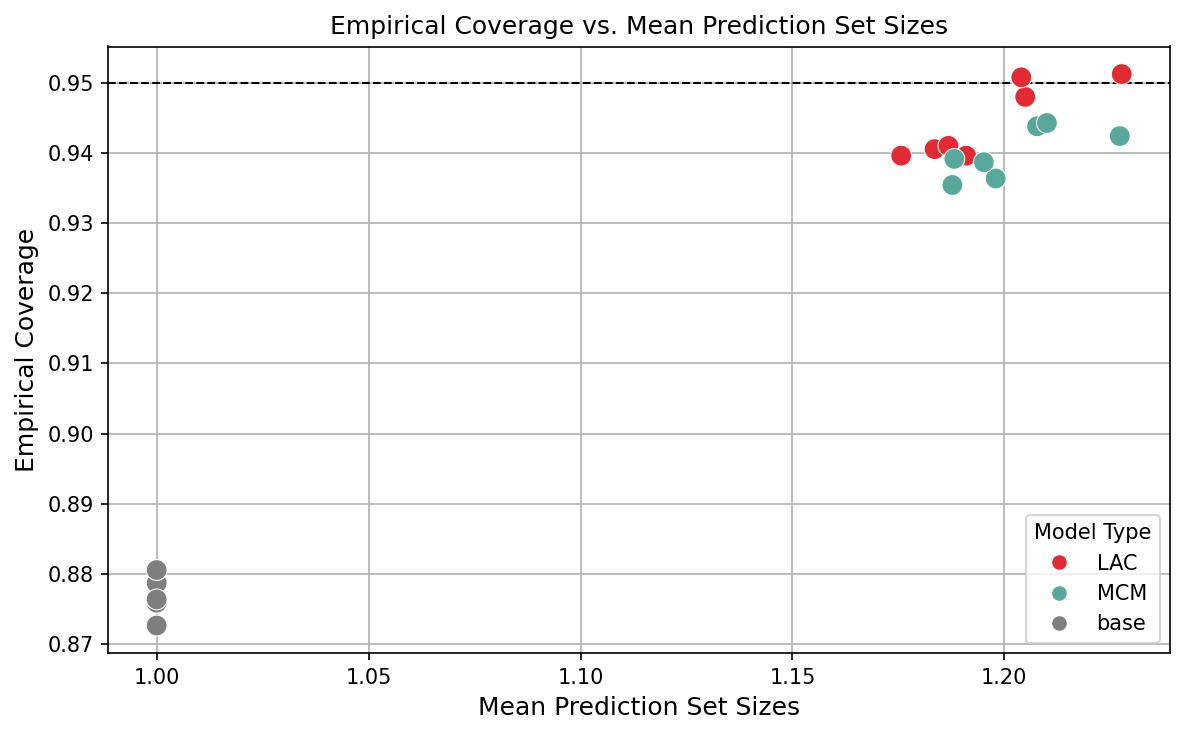

In [49]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'LAC': '#e02b35', 'MCM': '#59a89c'}
df_AMM_by_run_to_plot = df_AMM_by_run.copy()
df_AMM_by_run_to_plot['color'] = df_AMM_by_run_to_plot['pred_model_type'].map(color_dict).fillna('black')

#
plot_coverage_vs_set_size(
    mean_set_sizes=df_AMM_by_run_to_plot['mean_set_size'],
    empirical_coverages=df_AMM_by_run_to_plot['empirical_coverage'],
    model_types=df_AMM_by_run_to_plot['pred_model_type'],
    colors=df_AMM_by_run_to_plot['color'],
    confidence_level=0.95,
    figsize=(8, 5),
    dpi=150
)

## Matriz de confusión conformal

In [50]:
# Añadir columna de ranking para 'mean_set_score' dentro de cada grupo
df_AMM_by_run = (
    df_AMM_by_run
    .sort_values(['pred_model_type', 'confidence', 'mean_set_size'])
    .assign(
        ranking_mean_set_score=lambda x: x.groupby(['pred_model_type', 'confidence'])['mean_set_score']
                                             .rank(method='dense')
    )
)

# Filtrar las mejores ejecuciones (ranking = 1)
best_runs = (
    df_AMM_by_run[df_AMM_by_run['ranking_mean_set_score'] == 1]
    [['pred_model_type', 'confidence', 'iteration']]
)

# Unir con los datos originales para obtener solo la instancias de las mejores ejecuciones
df_best_AMM_raw = pd.merge(
    df_AMM_raw,
    best_runs,
    on=['pred_model_type', 'confidence', 'iteration'],
    how='inner'  # Solo conserva las coincidencias
)

display(df_best_AMM_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


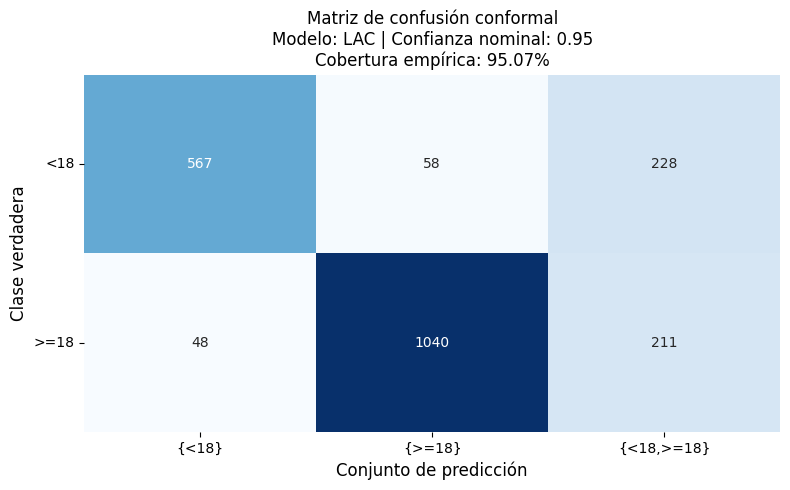

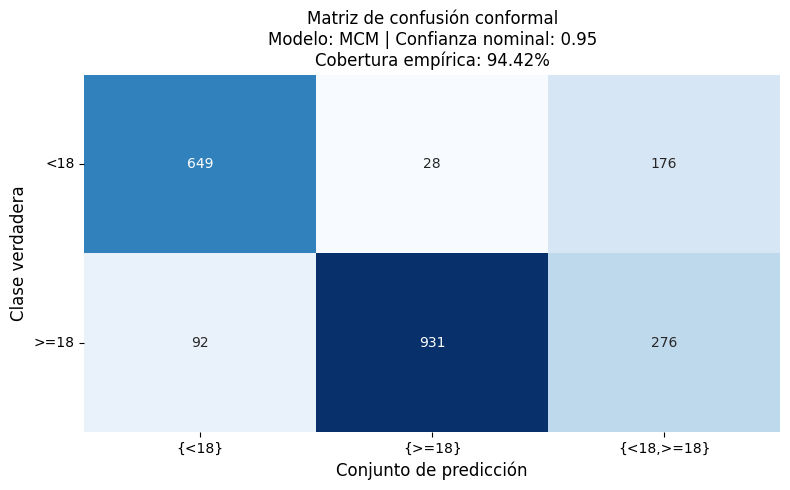

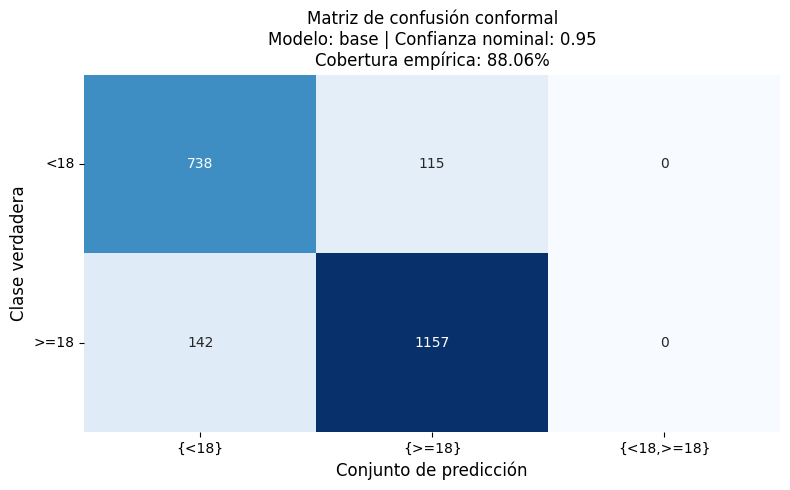

In [51]:
def pred_set_label(row):
    if row['pred_set_under_18'] == 1 and row['pred_set_over_18'] == 0:
        return '{<18}'
    elif row['pred_set_under_18'] == 0 and row['pred_set_over_18'] == 1:
        return '{>=18}'
    elif row['pred_set_under_18'] == 1 and row['pred_set_over_18'] == 1:
        return '{<18,>=18}'
    else:
        return '∅'  # Por si acaso, aunque dices que nunca ocurre

df_best_AMM_raw['pred_set_label'] = df_best_AMM_raw.apply(pred_set_label, axis=1)

confusion_conformal = (
    df_best_AMM_raw
    .groupby(['pred_model_type', 'confidence', 'true_class', 'pred_set_label'])
    .size()
    .reset_index(name='count')
)

empirical_coverage_by_group = (
    df_best_AMM_raw
    .groupby(['pred_model_type', 'confidence'])['is_covered']
    .mean()
    .reset_index(name='empirical_coverage')
)

coverage_dict = {
    (row['pred_model_type'], row['confidence']): row['empirical_coverage']
    for _, row in empirical_coverage_by_group.iterrows()
}

# Posibles etiquetas de columnas en orden
pred_set_labels = ['{<18}', '{>=18}', '{<18,>=18}']

# Dibujar una matriz por cada combinación
for (model, conf), group in confusion_conformal.groupby(['pred_model_type', 'confidence']):
    # Crear tabla cruzada (confusion matrix)
    pivot = group.pivot(index='true_class', columns='pred_set_label', values='count').fillna(0)

    # Asegurar columnas en orden
    for label in pred_set_labels:
        if label not in pivot.columns:
            pivot[label] = 0
    pivot = pivot[pred_set_labels]
    
    coverage = coverage_dict.get((model, conf), None)
    coverage_str = f'{coverage:.2%}' if coverage is not None else 'N/A'

    # Plot
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Blues', cbar=False)
    plt.title(f'Matriz de confusión conformal\nModelo: {model} | Confianza nominal: {conf}\nCobertura empírica: {coverage_str}')
    plt.xlabel('Conjunto de predicción', fontsize=12)
    plt.ylabel('Clase verdadera', fontsize=12)
    plt.yticks([0.5, 1.5], ['<18', '>=18'], rotation=0)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [52]:
# def plot_stacked_pred_set_distribution(df: pl.DataFrame):

#     # Paso 1: Crear columna categórica pred_set_type usando pl.when-then encadenado con pl.coalesce
#     pred_set_type_expr = pl.coalesce(
#         pl.when((pl.col('pred_set_under_18') == 1) & (pl.col('pred_set_over_18') == 0)).then(pl.lit('only_0')),
#         pl.when((pl.col('pred_set_under_18') == 1) & (pl.col('pred_set_over_18') == 1)).then(pl.lit('both')),
#         pl.when((pl.col('pred_set_under_18') == 0) & (pl.col('pred_set_over_18') == 1)).then(pl.lit('only_1')),
#         pl.lit('none')
#     ).alias('pred_set_type')

#     # Paso 2: Agrupar
#     grouped = df.group_by(
#         ['pred_model_type', 'confidence', 'iteration', 'pred_set_type']
#     ).agg([
#         pl.count().alias('count')
#     ])

#     # Paso 3: Pivotear
#     pivoted = grouped.pivot(
#         values='count',
#         index=['pred_model_type', 'iteration'],
#         columns='pred_set_type',
#         aggregate_function='first'
#     ).fill_null(0)

#     # Paso 4: Convertir y asegurar columnas
#     df_plot = pivoted.to_pandas()
#     df_plot['x_label'] = df_plot['pred_model_type'] + '_iter_' + df_plot['iteration'].astype(str)

#     for col in ['only_0', 'both', 'only_1']:
#         if col not in df_plot.columns:
#             df_plot[col] = 0

#     # Paso 5: Plot
#     x = np.arange(len(df_plot['x_label']))
#     only_0 = df_plot['only_0']
#     both = df_plot['both']
#     only_1 = df_plot['only_1']

#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.bar(x, only_0, label='{0}', color='#9ecae1')
#     ax.bar(x, both, bottom=only_0, label='{0,1}', color='#6baed6')
#     ax.bar(x, only_1, bottom=only_0 + both, label='{1}', color='#2171b5')

#     ax.set_xticks(x)
#     ax.set_xticklabels(df_plot['x_label'], rotation=45, ha='right')
#     ax.set_ylabel('Número de instancias')
#     ax.set_title('Distribución de conjuntos de predicción por modelo e iteración')
#     ax.legend(title='Pred set')

#     plt.tight_layout()
#     plt.show()

# PROBLEMA 3
# ESTIMACIÓN DE CLASIFICACIÓN EN SEXO Y MAYORÍA DE EDAD

## Carga de datos

In [57]:
# Carga de datos
df_AMSC_raw = pd.read_csv('results/AMSC_maxillofacial_test_results.csv')

display(df_AMSC_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [58]:
# Nueva columna: cobertura (true/false)
df_AMSC_raw['well_classified'] = (df_AMSC_raw['true_class'] == df_AMSC_raw['pred_class'])

# Nueva columna: cobertura (true/false)
df_AMSC_raw['is_covered'] = (
    ((df_AMSC_raw['true_class'] == 0) & (df_AMSC_raw['pred_set_male_under_18'] == 1)) |
    ((df_AMSC_raw['true_class'] == 1) & (df_AMSC_raw['pred_set_male_over_18'] == 1)) |
    ((df_AMSC_raw['true_class'] == 2) & (df_AMSC_raw['pred_set_female_under_18'] == 1)) |
    ((df_AMSC_raw['true_class'] == 3) & (df_AMSC_raw['pred_set_female_over_18'] == 1))
)

# Nueva columna: tamaño del conjunto de predicción
df_AMSC_raw['pred_set_size'] = (
    df_AMSC_raw['pred_set_male_under_18'] + df_AMSC_raw['pred_set_male_over_18'] + 
    df_AMSC_raw['pred_set_female_under_18'] + df_AMSC_raw['pred_set_female_over_18']
)

# Nueva columna: set score
alpha = 1 - df_AMSC_raw['confidence']
df_AMSC_raw['set_score'] = df_AMSC_raw['pred_set_size'] + 1/alpha * (~df_AMSC_raw['is_covered'])

display(df_AMSC_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [59]:
# Agrupar y calcular métricas
df_AMSC_by_run = (
    df_AMSC_raw
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': g['well_classified'].mean(),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean()
    }))
    .reset_index()
)

display(df_AMSC_by_run)

/tmp/ipykernel_34167/16689953.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Tabla resumen por ejecución y media

In [60]:
# Redondear valores y formatear porcentaje
df_AMSC_by_run_to_show = df_AMSC_by_run.copy()
df_AMSC_by_run_to_show['accuracy'] = df_AMSC_by_run_to_show['accuracy'].round(2)
df_AMSC_by_run_to_show['empirical_coverage'] = (df_AMSC_by_run_to_show['empirical_coverage'] * 100).round(2)
df_AMSC_by_run_to_show['mean_set_size'] = df_AMSC_by_run_to_show['mean_set_size'].round(2)
df_AMSC_by_run_to_show['mean_set_score'] = df_AMSC_by_run_to_show['mean_set_score'].round(2)

# Ordenar por iteración y por tipo de predicción
df_AMSC_by_run_to_show = sort_by_column(df_AMSC_by_run_to_show, 'iteration')
custom_order = ['base', 'LAC', 'MCM']
df_AMSC_by_run_to_show = sort_by_column(df_AMSC_by_run_to_show, 'pred_model_type', custom_order)

display(df_AMSC_by_run_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## OTRA COSA